
# **The Data Science Method**  


1.   [Problem Identification](https://medium.com/@aiden.dataminer/the-data-science-method-problem-identification-6ffcda1e5152)

2.   [**Data Wrangling**](https://medium.com/@aiden.dataminer/the-data-science-method-dsm-data-collection-organization-and-definitions-d19b6ff141c4) 
  * Data Organization - Using cookiecutter template with some modifications to start.
  * Data Collection - Collected data from wikipedia and yahoo finance price dataset. The wikipedia showed us the current S&P 500 companies and then used their ticker symbols to query yahoo finance adj. close prices.
      - Load the S&P 500 tickers from wikipedia page
      - Get S&P 500 Index (^GSPC) as a Bench Mark
      - Use S&P Symbols to Get Adj Close from Yahoo Finance
  * Data Cleaning - The S&P 500 data from yahoo finance price is almost clean and ready for analysis use. Need to remove tickers that IPO or die mid year, creating usable Nan values.
  * Basic Data Visualizations 
  * Data Definition 

 
3.   [Exploratory Data Analysis](https://medium.com/@aiden.dataminer/the-data-science-method-dsm-exploratory-data-analysis-bc84d4d8d3f9)
 * Build data profile tables and plots
        - Cumulative Return
        - Annualized Return
        - Daily Return
        - Mean Daily Return
        - Standard Deviation Daily Return
        - Simple Moving Average
        - Exponential Moving Average
        - Moving Average Convergence Divergence
        - Adj. Close & Daily Return Covariance
        - Adj. Close & Daily Return Correlation
        - Sharpe Ratio
        - Skew 
        - Kurtosis
 * Explore data relationships
 * Identification and creation of features 

4.   [Pre-processing and Training Data Development](https://medium.com/@aiden.dataminer/the-data-science-method-dsm-pre-processing-and-training-data-development-fd2d75182967)
  * Create dummy or indicator features for categorical variables
  * Standardize the magnitude of numeric features
  * Split into testing and training datasets
  * Apply scalar to the testing set
5.   [Modeling](https://medium.com/@aiden.dataminer/the-data-science-method-dsm-modeling-56b4233cad1b)
  * Create dummy or indicator features for categorical variable
  * Fit Models with Training Data Set
  * Review Model Outcomes — Iterate over additional models as needed.
  * Identify the Final Model

6.   [Documentation](https://medium.com/@aiden.dataminer/the-data-science-method-dsm-documentation-c92c28bd45e6)

  * Review the Results
  * Present and share your findings - storytelling
  * Finalize Code 
  * Finalize Documentation



# Data Wrangling

## Data Organization

First, loads the needed packages and modules into Python. 
Then, look at project data structure similar to cookie cutter to create directory path variables.

In [1]:
#load python packages
import os
from bs4 import BeautifulSoup
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from yahooquery import Ticker
import requests

import datetime as dt
import scipy.optimize as spo
from tqdm import tqdm

from IPython.display import display
import ipywidgets as widgets


In [2]:
# prints current directory 
current_dir = os.getcwd() 
print("Current Directory: ") 
print(current_dir) 

Current Directory: 
/Users/jb/Development/courses/springboard/ds/Assignments/Portfolio-Optimization/portopt/notebooks/exploratory


In [3]:
# prints parent directory 
project_dir = os.path.abspath(os.path.join(os.path.join(current_dir, os.pardir), os.pardir))
print("Parent Directory: ") 
print(project_dir) 

Parent Directory: 
/Users/jb/Development/courses/springboard/ds/Assignments/Portfolio-Optimization/portopt


In [4]:
os.chdir(project_dir)
os.listdir()

['.DS_Store', 'models', 'weights.csv', 'data', 'notebooks', 'reports', 'src']

In [5]:
data_interim_dir = '/data/interim/'
data_raw_dir = '/data/raw/'

## Data Collection

Setup for future visualizations.

In [6]:
%matplotlib inline

plt.style.use('dark_background')
c = ['white', 'springgreen', 'fuchsia', 'lightcoral', 'red'] # Color
s = [24, 20, 16, 12]  # Size
w = [0.75, 1, 1.25, 1.50] # Line Width
ga = 0.10 # Grid Alpha

The start and end date window for S&P 500 analysis

In [7]:
start_date = "1999-01-01"
end_date = "2020-01-01"

### Load the S&P 500 tickers from wikipedia page - https://en.wikipedia.org/wiki/List_of_S&P_500_companies

We will find the current S&P 500 companies from wikipedia using pandas html table scraper.
Read S&P 500 data into a list, pandas dataframe and save in csv for future pipelining.


In [8]:
input_url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
wiki_tables = pd.read_html(input_url)
for table in wiki_tables:
    print(table.head())
    print('-----------------------------------------------------------------------------------------')

  Symbol             Security SEC filings             GICS Sector  \
0    MMM           3M Company     reports             Industrials   
1    ABT  Abbott Laboratories     reports             Health Care   
2   ABBV          AbbVie Inc.     reports             Health Care   
3   ABMD          ABIOMED Inc     reports             Health Care   
4    ACN        Accenture plc     reports  Information Technology   

                GICS Sub-Industry    Headquarters Location Date first added  \
0        Industrial Conglomerates      St. Paul, Minnesota       1976-08-09   
1           Health Care Equipment  North Chicago, Illinois       1964-03-31   
2                 Pharmaceuticals  North Chicago, Illinois       2012-12-31   
3           Health Care Equipment   Danvers, Massachusetts       2018-05-31   
4  IT Consulting & Other Services          Dublin, Ireland       2011-07-06   

       CIK      Founded  
0    66740         1902  
1     1800         1888  
2  1551152  2013 (1888)  
3   81

In [9]:
wiki_df = wiki_tables[0]
print(wiki_df.head())


  Symbol             Security SEC filings             GICS Sector  \
0    MMM           3M Company     reports             Industrials   
1    ABT  Abbott Laboratories     reports             Health Care   
2   ABBV          AbbVie Inc.     reports             Health Care   
3   ABMD          ABIOMED Inc     reports             Health Care   
4    ACN        Accenture plc     reports  Information Technology   

                GICS Sub-Industry    Headquarters Location Date first added  \
0        Industrial Conglomerates      St. Paul, Minnesota       1976-08-09   
1           Health Care Equipment  North Chicago, Illinois       1964-03-31   
2                 Pharmaceuticals  North Chicago, Illinois       2012-12-31   
3           Health Care Equipment   Danvers, Massachusetts       2018-05-31   
4  IT Consulting & Other Services          Dublin, Ireland       2011-07-06   

       CIK      Founded  
0    66740         1902  
1     1800         1888  
2  1551152  2013 (1888)  
3   81


Save wiki query dataframe in raw directory.

In [10]:
wiki_df.to_csv(project_dir + '/data/raw/'+ 'wiki_sp500_raw.csv', index=False)

In [11]:
# wiki_df = pd.read_csv(project_dir + '/data/raw/'+ 'wiki_sp500_raw.csv', index_col=['index'])
# wiki_df

In [12]:
wiki_df['Symbol'] = wiki_df['Symbol'].str.replace('.', '-', regex=False)
sp500_ticker_list = wiki_df['Symbol']

In [13]:
# from src.data.get_data import WikipediaData
# wd = WikipediaData()
# wd.get_raw_data()
# wd.clean_data()
# wiki_df = wd.df
# sp500_ticker_list = wiki_df.Symbol


Let's take a look at the SP500 GICS Sector & sub sector count to see the how many tickers correspond to each sector. 

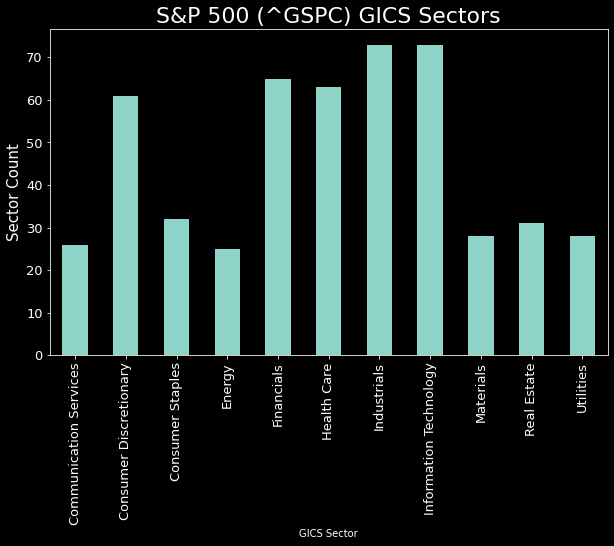

In [14]:
wiki_df_sectors = wiki_df.groupby(["GICS Sector"])["Symbol"].count()

ax = wiki_df_sectors.plot(kind='bar', figsize=(10,6), fontsize=13)
ax.set_alpha(0.8)
ax.set_title("S&P 500 (^GSPC) GICS Sectors", fontsize=22)
ax.set_ylabel("Sector Count", fontsize=15)
plt.show()


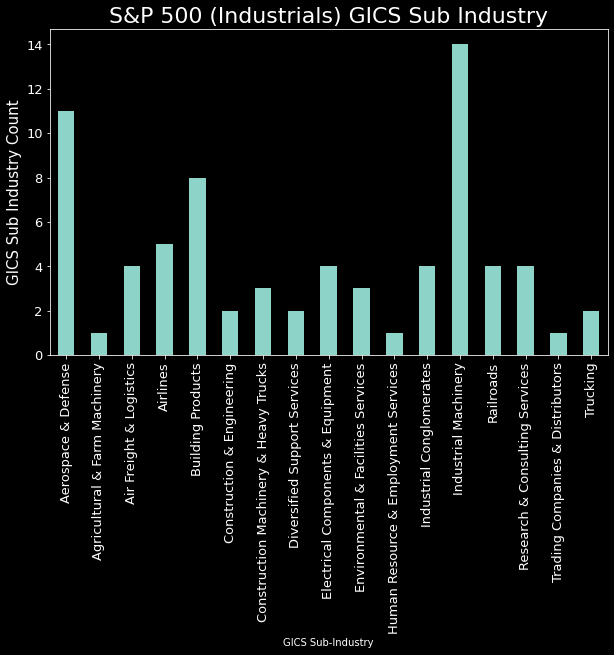

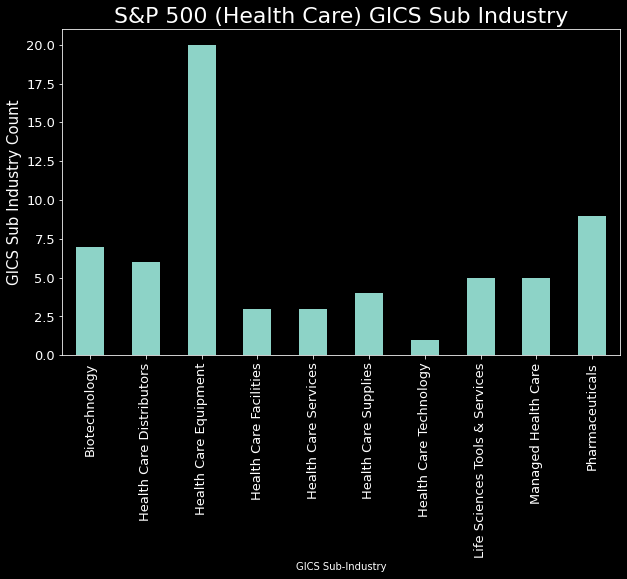

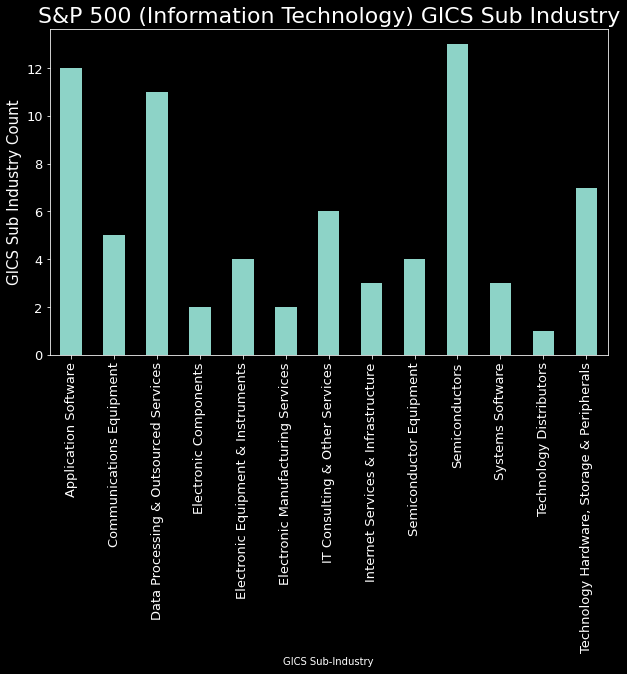

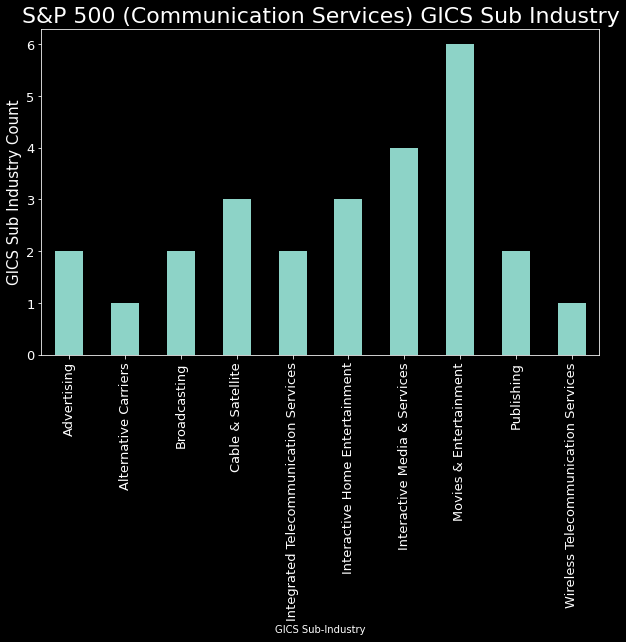

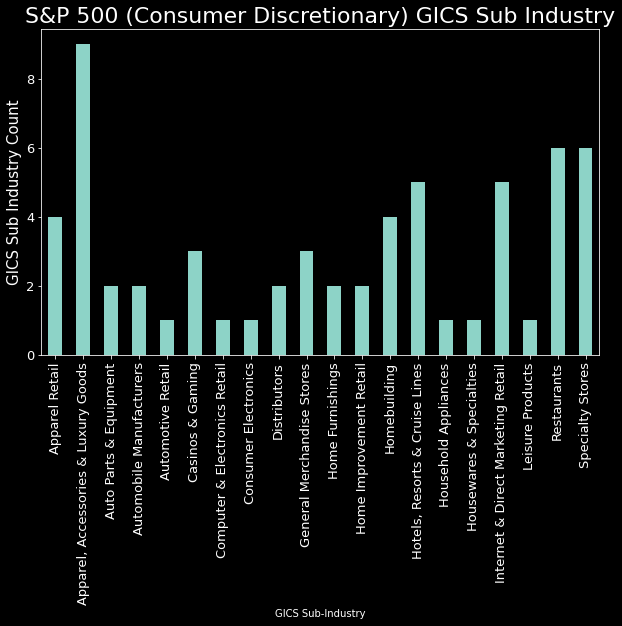

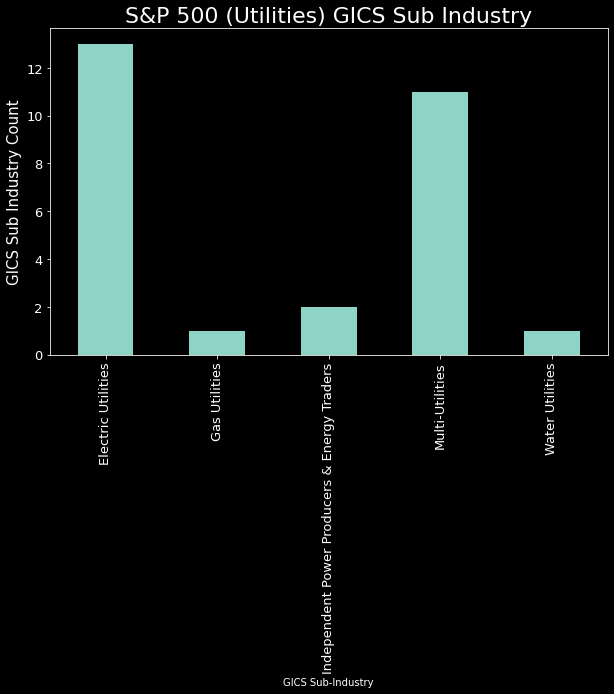

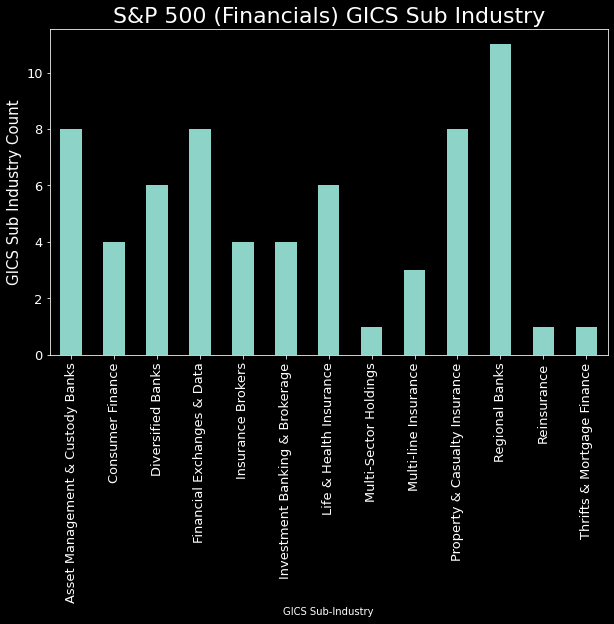

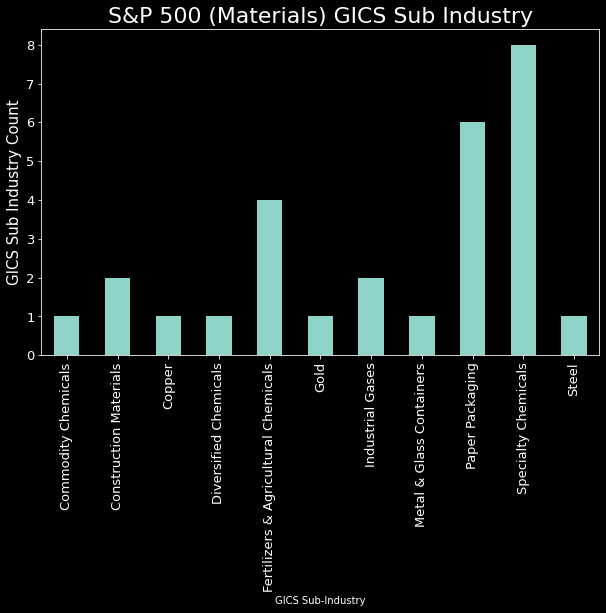

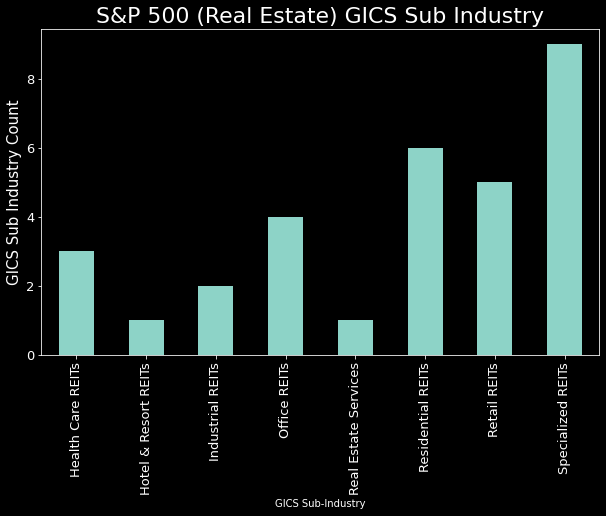

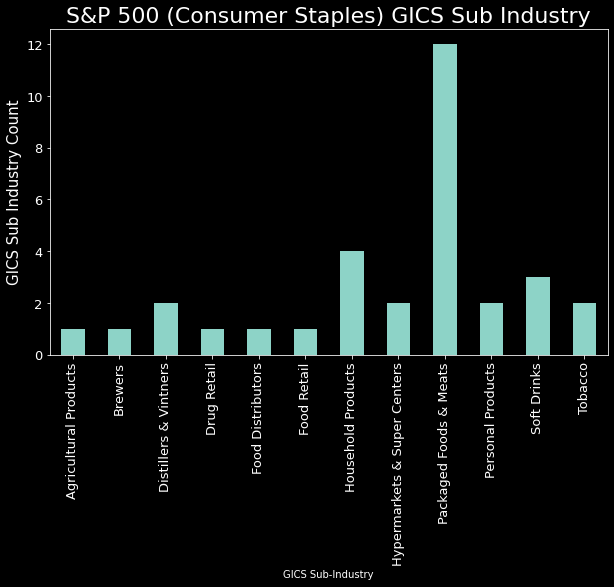

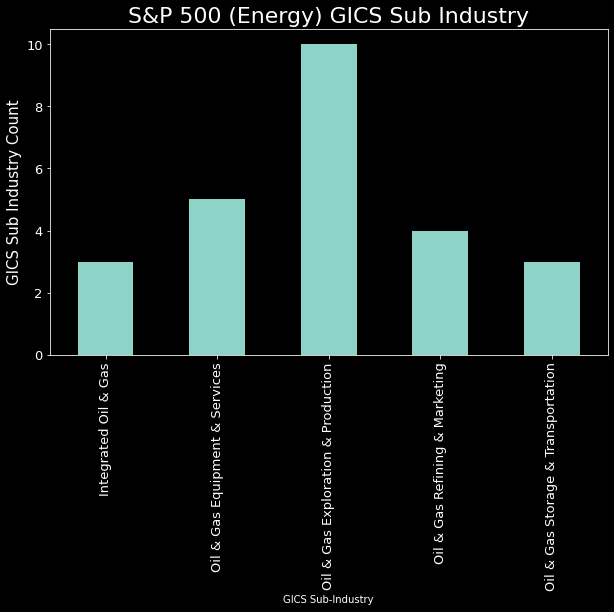

In [15]:
wiki_df_sectors_sub_ind = wiki_df.groupby(["GICS Sector", "GICS Sub-Industry"])["Symbol"].count()
sp500_sectors = wiki_df["GICS Sector"].unique()

for sector in sp500_sectors:
    sp500_sector = wiki_df[wiki_df["GICS Sector"] == sector]
    wiki_df_sub_sectors = sp500_sector.groupby(["GICS Sub-Industry"])["Symbol"].count()

    ax = wiki_df_sub_sectors.plot(kind='bar', figsize=(10,6), fontsize=13)
    ax.set_alpha(0.8)
    ax.set_title(f"S&P 500 ({sector}) GICS Sub Industry", fontsize=22)
    ax.set_ylabel("GICS Sub Industry Count", fontsize=15)
    plt.show()

In [16]:
wiki_df.groupby(["GICS Sector", "GICS Sub-Industry"])["Symbol"].count().tail(60)

GICS Sector             GICS Sub-Industry                           
Health Care             Health Care Services                             3
                        Health Care Supplies                             4
                        Health Care Technology                           1
                        Life Sciences Tools & Services                   5
                        Managed Health Care                              5
                        Pharmaceuticals                                  9
Industrials             Aerospace & Defense                             11
                        Agricultural & Farm Machinery                    1
                        Air Freight & Logistics                          4
                        Airlines                                         5
                        Building Products                                8
                        Construction & Engineering                       2
                        Constru

### Load the S&P 500 weights per tickers via  slick charts sp500 page - https://www.slickcharts.com/sp500

In [17]:
input_url = "https://www.slickcharts.com/sp500"
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
res = requests.get(input_url, headers=headers)

soup = BeautifulSoup(res.content, 'lxml')
tables = soup.find_all('table') 

slick_df = pd.read_html(str(tables[0]))[0]
print(slick_df.head())

   #                Company Symbol    Weight    Price   Chg     % Chg
0  1             Apple Inc.   AAPL  6.198652   116.44 -0.15  (-0.13%)
1  2  Microsoft Corporation   MSFT  5.378336   215.24  0.01   (0.00%)
2  3        Amazon.com Inc.   AMZN  4.506496  3198.00  2.66   (0.08%)
3  4  Facebook Inc. Class A     FB  2.201843   277.89  0.08   (0.03%)
4  5  Alphabet Inc. Class A  GOOGL  1.761306  1787.02  0.00   (0.00%)


Save slick query dataframe in raw directory.

In [18]:
slick_df.to_csv(project_dir + '/data/raw/'+ 'sp500_slick_df_raw.csv', index=False)

In [19]:
# slick_df = pd.read_csv(project_dir + '/data/raw/'+ 'sp500_slick_df_raw.csv')
# slick_df

In [20]:
print(slick_df.Weight.sum())
print(slick_df.shape)
print(slick_df)


99.99339000000002
(505, 7)
       #                    Company Symbol    Weight    Price   Chg     % Chg
0      1                 Apple Inc.   AAPL  6.198652   116.44 -0.15  (-0.13%)
1      2      Microsoft Corporation   MSFT  5.378336   215.24  0.01   (0.00%)
2      3            Amazon.com Inc.   AMZN  4.506496  3198.00  2.66   (0.08%)
3      4      Facebook Inc. Class A     FB  2.201843   277.89  0.08   (0.03%)
4      5      Alphabet Inc. Class A  GOOGL  1.761306  1787.02  0.00   (0.00%)
..   ...                        ...    ...       ...      ...   ...       ...
500  501             TechnipFMC Plc    FTI  0.012637     8.97  0.00   (0.00%)
501  502  HollyFrontier Corporation    HFC  0.012431    24.93  0.00   (0.00%)
502  503  Under Armour Inc. Class A    UAA  0.010166    16.68  0.00   (0.00%)
503  504  Under Armour Inc. Class C     UA  0.009527    14.71  0.00   (0.00%)
504  505   News Corporation Class B    NWS  0.007377    17.81  0.00   (0.00%)

[505 rows x 7 columns]


In [21]:
# from src.data.get_data import SlickData
# sd = SlickData()
# sd.get_raw_data()
# sd.clean_data()
# slick_df = sd.df


### Get S&P 500 Index (^GSPC) as a Bench Mark from Yahoo Finance with yahooquery's Ticker

In [22]:
tickers = Ticker(['^GSPC'], asynchronous=True)
yf_data = tickers.history(start=start_date, end=end_date)

adj_close_df = yf_data.adjclose
adj_close_df.index.name = 'date'
adj_close_df = adj_close_df.reset_index(level='symbol')
adj_close_df = adj_close_df.pivot(columns='symbol')
adj_close_df.columns = [col[1] for col in adj_close_df.columns]
adj_close_df.index = pd.to_datetime(adj_close_df.index)


yahoo_sp500_index_adj_close_df = adj_close_df.copy()


In [23]:
yahoo_sp500_index_adj_close_df.to_csv(project_dir + '/data/raw/'+ 'yahoo_sp500_index_adj_close_raw.csv', index=False)

In [24]:
# yahoo_sp500_index_adj_close_df = pd.read_csv(project_dir + '/data/raw/'+ 'yahoo_sp500_adj_close_raw.csv')
# yahoo_sp500_index_adj_close_df.index = pd.to_datetime(yahoo_sp500_index_adj_close_df.index)
# yahoo_sp500_index_adj_close_df


In [25]:
type(yahoo_sp500_index_adj_close_df.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [26]:
# from src.data.get_data import YahooFinanceData
# yfd_sp500_index = YahooFinanceData(['^GSPC'], 'sp500_index', start, end)
# yfd_sp500_index.get_raw_data()
# yfd_sp500_index.clean_data()
# yahoo_sp500_index_adj_close_df = yfd_sp500_index.adj_close_df

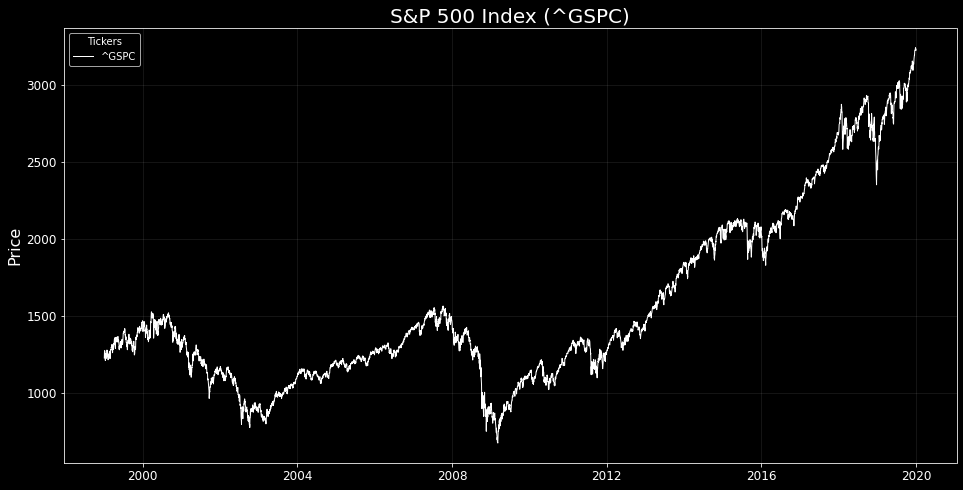

In [27]:
fig, ax1 = plt.subplots(1, figsize=(16, 8))
  
ax1.set_title(f"S&P 500 Index (^GSPC)", fontsize=s[1])
ax1.set_ylabel(f"Price", fontsize=s[2])
ax1.plot(yahoo_sp500_index_adj_close_df.index.values, yahoo_sp500_index_adj_close_df['^GSPC'], label='^GSPC', linewidth=w[1], color=c[0])
ax1.legend(loc='upper left', title = 'Tickers')
ax1.grid(alpha=ga)

plt.xticks(fontsize=s[3])
plt.yticks(fontsize=s[3])
plt.show()


### Use S&P Symbols to Get Adj Close from Yahoo Finance

In [28]:
sp500_ticker_list

0       MMM
1       ABT
2      ABBV
3      ABMD
4       ACN
       ... 
500     YUM
501    ZBRA
502     ZBH
503    ZION
504     ZTS
Name: Symbol, Length: 505, dtype: object

In [29]:
tickers = Ticker(sp500_ticker_list, asynchronous=True)

In [30]:
yf_data = tickers.history(start=start_date, end=end_date)
print(yf_data)

{'MMM':                    low       close        open        high   volume  \
1999-01-04   36.093750   37.312500   36.187500   37.687500  3661000   
1999-01-05   37.250000   37.531250   37.375000   38.375000  2468600   
1999-01-06   37.906250   39.281250   37.937500   39.281250  3169400   
1999-01-07   37.687500   38.375000   38.500000   38.531250  2173000   
1999-01-08   37.468750   38.562500   38.250000   39.000000  2567000   
...                ...         ...         ...         ...      ...   
2019-12-24  176.039993  176.679993  178.270004  178.669998  1259500   
2019-12-26  175.500000  176.589996  176.449997  176.660004  1435200   
2019-12-27  175.619995  177.259995  176.649994  177.539993  1472900   
2019-12-30  175.589996  175.830002  177.259995  178.960007  1715100   
2019-12-31  175.070007  176.419998  175.229996  176.589996  1573500   

              adjclose  dividends  splits  
1999-01-04   21.451324        NaN     NaN  
1999-01-05   21.577085        NaN     NaN  
1999-01

In [31]:
good_tickers = []
error_tickers = {}
for k, v in yf_data.items():
    if isinstance(v, pd.DataFrame):
        adj_close_df = pd.DataFrame(v.adjclose)
        adj_close_df.rename(columns={'adjclose': k}, inplace=True)
        good_tickers.append(adj_close_df)
    else:
        error_tickers[k] = v
    
adj_close_df = pd.concat(good_tickers, axis=1)

yahoo_sp500_adj_close_df = adj_close_df.copy()
yahoo_sp500_adj_close_df.index.name = 'date'

yahoo_sp500_adj_close_df.index = pd.to_datetime(yahoo_sp500_adj_close_df.index)


In [32]:
yahoo_sp500_adj_close_df.to_csv(project_dir + '/data/raw/'+ 'yahoo_sp500_adj_close_raw.csv', index=False)

In [33]:
# yahoo_sp500_adj_close_df = pd.read_csv(project_dir + '/data/raw/'+ 'yahoo_sp500_adj_close_raw.csv')
# yahoo_sp500_adj_close_df.index = pd.to_datetime(yahoo_sp500_adj_close_df.index)
# yahoo_sp500_adj_close_df

In [34]:
yahoo_sp500_adj_close_df.head()

,MMM,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,...,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBRA,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
1999-01-04,21.451324,13.125938,NaN,4.4375,NaN,0.812146,6.183796,14.00000,NaN,18.782715,...,NaN,10.390732,102.372307,11.795401,NaN,6.405311,13.055555,NaN,42.940239,NaN
1999-01-05,21.577085,13.142764,NaN,4.6250,NaN,0.807479,6.052223,13.84375,NaN,18.710747,...,NaN,10.414406,104.328484,12.292870,NaN,6.530091,13.277778,NaN,42.806744,NaN
1999-01-06,22.583176,13.041796,NaN,4.5000,NaN,0.821481,5.835520,13.62500,NaN,18.710747,...,NaN,10.461740,106.338966,12.193371,NaN,6.629915,13.305555,NaN,42.851254,NaN
1999-01-07,22.062164,12.873511,NaN,4.3750,NaN,0.816814,5.959351,13.71875,NaN,18.230989,...,NaN,10.414406,105.849945,12.104936,NaN,6.596642,13.611111,NaN,42.539764,NaN
1999-01-08,22.169964,12.823030,NaN,4.5000,NaN,0.807479,6.044486,14.00000,NaN,17.559324,...,NaN,10.343398,105.360878,12.115988,NaN,6.613274,15.111111,NaN,42.628750,NaN


In [35]:
yf_data_key_stats = tickers.key_stats
bad_ticker_stats = [k for k, v in yf_data_key_stats.items() if isinstance(v, str)]
[yf_data_key_stats.pop(key) for key in bad_ticker_stats]
sp500_yf_df = pd.DataFrame.from_dict(yf_data_key_stats).T
shares_outstanding_df = sp500_yf_df[['sharesOutstanding']]
shares_outstanding_df.index.name = 'symbol'
yahoo_sp500_shares_outstanding_df = shares_outstanding_df.copy()


In [36]:
yahoo_sp500_shares_outstanding_df.head()

,sharesOutstanding
symbol,
MMM,576822016
ABBV,1765469952
ABT,1772359936
ACN,635000000
AMD,1202710016


## Data Cleaning
The S&P 500 data from yahoo finance adj close price is almost clean and ready for analysis use. we need to remove tickers that IPO or die mid year, dropping unusable Nan values between specified dates.

In [37]:
error_tickers_list = list(error_tickers.keys())
print(error_tickers_list)

['CARR', 'LUMN', 'OTIS', 'VNT']


In [38]:

print(start_date, ' through ', end_date ,
      '\n------------------------------------------------------------------------------\n')
for k, v in error_tickers.items():
    print(k, '\t', v)


1999-01-01  through  2020-01-01 
------------------------------------------------------------------------------

CARR 	 Data doesn't exist for startDate = 915177600, endDate = 1577865600
LUMN 	 {'meta': {'currency': 'USD', 'symbol': 'LUMN', 'exchangeName': 'NYQ', 'instrumentType': 'EQUITY', 'firstTradeDate': 322151400, 'regularMarketTime': 1606500002, 'gmtoffset': -18000, 'timezone': 'EST', 'exchangeTimezoneName': 'America/New_York', 'regularMarketPrice': 10.46, 'chartPreviousClose': 10.52, 'priceHint': 2, 'currentTradingPeriod': {'pre': {'timezone': 'EST', 'start': 1606467600, 'end': 1606487400, 'gmtoffset': -18000}, 'regular': {'timezone': 'EST', 'start': 1606487400, 'end': 1606500000, 'gmtoffset': -18000}, 'post': {'timezone': 'EST', 'start': 1606500000, 'end': 1606525200, 'gmtoffset': -18000}}, 'dataGranularity': '1d', 'range': '', 'validRanges': ['1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max']}, 'indicators': {'quote': [{}], 'adjclose': [{}]}}
OTIS 	 Data d

#### Check for Nan values

In [39]:
# tickers_with_nan_values = yahoo_sp500_adj_close_df.columns[yahoo_sp500_adj_close_df.isna().any()].tolist()

def get_na_price_value_list(prices_df):
    return prices_df.columns[prices_df.isna().any()].tolist()

tickers_with_nan_values = get_na_price_value_list(yahoo_sp500_adj_close_df)
print(tickers_with_nan_values)


['ABBV', 'ACN', 'AAP', 'A', 'AKAM', 'ALGN', 'ALLE', 'GOOGL', 'GOOG', 'AMCR', 'AAL', 'AWK', 'AMP', 'ANTM', 'APTV', 'ANET', 'AIZ', 'BLK', 'BKNG', 'AVGO', 'BR', 'CTLT', 'CBOE', 'CBRE', 'CDW', 'CE', 'CNC', 'CF', 'CHTR', 'CMG', 'CFG', 'CME', 'CXO', 'CTVA', 'DAL', 'DXCM', 'FANG', 'DLR', 'DFS', 'DISCA', 'DISCK', 'DG', 'DPZ', 'DOW', 'EW', 'EQIX', 'ETSY', 'EXPE', 'EXR', 'FFIV', 'FB', 'FIS', 'FRC', 'FLT', 'FTNT', 'FTV', 'FBHS', 'FOXA', 'FOX', 'GRMN', 'GM', 'GPN', 'GS', 'HBI', 'HCA', 'HPE', 'HLT', 'HWM', 'HII', 'INFO', 'ILMN', 'IR', 'ICE', 'ISRG', 'IPGP', 'IQV', 'JNPR', 'KEYS', 'KMI', 'KHC', 'LW', 'LVS', 'LDOS', 'LYV', 'LKQ', 'LYB', 'MPC', 'MKTX', 'MA', 'MET', 'MDLZ', 'MSCI', 'NDAQ', 'NFLX', 'NWSA', 'NWS', 'NLSN', 'NCLH', 'NRG', 'NVDA', 'PKG', 'PAYC', 'PYPL', 'PM', 'PSX', 'PFG', 'PRU', 'QRVO', 'CRM', 'SBAC', 'STX', 'NOW', 'SYF', 'TMUS', 'TPR', 'TEL', 'FTI', 'TDY', 'TDG', 'TWTR', 'ULTA', 'UAA', 'UA', 'UAL', 'UPS', 'VRSK', 'VIAC', 'V', 'WU', 'WRK', 'WLTW', 'WYNN', 'XYL', 'ZBH', 'ZTS']


#### Full list of usable tickers

In [40]:
[error_tickers_list.append(x) for x in tickers_with_nan_values]
print(error_tickers_list)
len(error_tickers_list)

['CARR', 'LUMN', 'OTIS', 'VNT', 'ABBV', 'ACN', 'AAP', 'A', 'AKAM', 'ALGN', 'ALLE', 'GOOGL', 'GOOG', 'AMCR', 'AAL', 'AWK', 'AMP', 'ANTM', 'APTV', 'ANET', 'AIZ', 'BLK', 'BKNG', 'AVGO', 'BR', 'CTLT', 'CBOE', 'CBRE', 'CDW', 'CE', 'CNC', 'CF', 'CHTR', 'CMG', 'CFG', 'CME', 'CXO', 'CTVA', 'DAL', 'DXCM', 'FANG', 'DLR', 'DFS', 'DISCA', 'DISCK', 'DG', 'DPZ', 'DOW', 'EW', 'EQIX', 'ETSY', 'EXPE', 'EXR', 'FFIV', 'FB', 'FIS', 'FRC', 'FLT', 'FTNT', 'FTV', 'FBHS', 'FOXA', 'FOX', 'GRMN', 'GM', 'GPN', 'GS', 'HBI', 'HCA', 'HPE', 'HLT', 'HWM', 'HII', 'INFO', 'ILMN', 'IR', 'ICE', 'ISRG', 'IPGP', 'IQV', 'JNPR', 'KEYS', 'KMI', 'KHC', 'LW', 'LVS', 'LDOS', 'LYV', 'LKQ', 'LYB', 'MPC', 'MKTX', 'MA', 'MET', 'MDLZ', 'MSCI', 'NDAQ', 'NFLX', 'NWSA', 'NWS', 'NLSN', 'NCLH', 'NRG', 'NVDA', 'PKG', 'PAYC', 'PYPL', 'PM', 'PSX', 'PFG', 'PRU', 'QRVO', 'CRM', 'SBAC', 'STX', 'NOW', 'SYF', 'TMUS', 'TPR', 'TEL', 'FTI', 'TDY', 'TDG', 'TWTR', 'ULTA', 'UAA', 'UA', 'UAL', 'UPS', 'VRSK', 'VIAC', 'V', 'WU', 'WRK', 'WLTW', 'WYNN', 'XY

139

#### Drop tickers with nans

In [41]:
# yahoo_sp500_adj_close_df = yahoo_sp500_adj_close_df.drop(tickers_with_nan_values)
# yahoo_sp500_adj_close_df

#### Find Start Dates For Each Stock

In [42]:
yahoo_sp500_adj_close_start_date_df = pd.DataFrame(data={'start_date': '1999-01-04 00:00:00'}, index=yahoo_sp500_adj_close_df.columns, columns=['start_date', 'nan_count_after_start_date'])
yahoo_sp500_adj_close_start_date_df.start_date = pd.to_datetime(yahoo_sp500_adj_close_start_date_df.start_date)

for ind in yahoo_sp500_adj_close_df.index:
    for element in yahoo_sp500_adj_close_df.columns:
        if np.isnan(yahoo_sp500_adj_close_df.loc[ind, element]):
            if yahoo_sp500_adj_close_start_date_df.loc[element, 'nan_count_after_start_date'] != 0:
                yahoo_sp500_adj_close_start_date_df.loc[element, 'nan_count_after_start_date'] = yahoo_sp500_adj_close_start_date_df.loc[element, 'nan_count_after_start_date'] + 1
        else:
            if yahoo_sp500_adj_close_start_date_df.loc[element, 'nan_count_after_start_date'] != 0:
                yahoo_sp500_adj_close_start_date_df.loc[element, 'nan_count_after_start_date'] = 0
                yahoo_sp500_adj_close_start_date_df.loc[element, 'start_date'] = ind
                print( yahoo_sp500_adj_close_start_date_df.loc[element, :])

                
                
yahoo_sp500_adj_close_start_date_df


start_date                    1999-01-04 00:00:00
nan_count_after_start_date                      0
Name: MMM, dtype: object
start_date                    1999-01-04 00:00:00
nan_count_after_start_date                      0
Name: ABT, dtype: object
start_date                    1999-01-04 00:00:00
nan_count_after_start_date                      0
Name: ABMD, dtype: object
start_date                    1999-01-04 00:00:00
nan_count_after_start_date                      0
Name: ATVI, dtype: object
start_date                    1999-01-04 00:00:00
nan_count_after_start_date                      0
Name: ADBE, dtype: object
start_date                    1999-01-04 00:00:00
nan_count_after_start_date                      0
Name: AMD, dtype: object
start_date                    1999-01-04 00:00:00
nan_count_after_start_date                      0
Name: AES, dtype: object
start_date                    1999-01-04 00:00:00
nan_count_after_start_date                      0
Name: AFL, dtype: obje

Name: CVX, dtype: object
start_date                    1999-01-04 00:00:00
nan_count_after_start_date                      0
Name: CB, dtype: object
start_date                    1999-01-04 00:00:00
nan_count_after_start_date                      0
Name: CHD, dtype: object
start_date                    1999-01-04 00:00:00
nan_count_after_start_date                      0
Name: CI, dtype: object
start_date                    1999-01-04 00:00:00
nan_count_after_start_date                      0
Name: CINF, dtype: object
start_date                    1999-01-04 00:00:00
nan_count_after_start_date                      0
Name: CTAS, dtype: object
start_date                    1999-01-04 00:00:00
nan_count_after_start_date                      0
Name: CSCO, dtype: object
start_date                    1999-01-04 00:00:00
nan_count_after_start_date                      0
Name: C, dtype: object
start_date                    1999-01-04 00:00:00
nan_count_after_start_date                      0
N

Name: K, dtype: object
start_date                    1999-01-04 00:00:00
nan_count_after_start_date                      0
Name: KEY, dtype: object
start_date                    1999-01-04 00:00:00
nan_count_after_start_date                      0
Name: KMB, dtype: object
start_date                    1999-01-04 00:00:00
nan_count_after_start_date                      0
Name: KIM, dtype: object
start_date                    1999-01-04 00:00:00
nan_count_after_start_date                      0
Name: KLAC, dtype: object
start_date                    1999-01-04 00:00:00
nan_count_after_start_date                      0
Name: KR, dtype: object
start_date                    1999-01-04 00:00:00
nan_count_after_start_date                      0
Name: LB, dtype: object
start_date                    1999-01-04 00:00:00
nan_count_after_start_date                      0
Name: LHX, dtype: object
start_date                    1999-01-04 00:00:00
nan_count_after_start_date                      0
Nam

Name: VTR, dtype: object
start_date                    1999-01-04 00:00:00
nan_count_after_start_date                      0
Name: VRSN, dtype: object
start_date                    1999-01-04 00:00:00
nan_count_after_start_date                      0
Name: VZ, dtype: object
start_date                    1999-01-04 00:00:00
nan_count_after_start_date                      0
Name: VRTX, dtype: object
start_date                    1999-01-04 00:00:00
nan_count_after_start_date                      0
Name: VFC, dtype: object
start_date                    1999-01-04 00:00:00
nan_count_after_start_date                      0
Name: VTRS, dtype: object
start_date                    1999-01-04 00:00:00
nan_count_after_start_date                      0
Name: VNO, dtype: object
start_date                    1999-01-04 00:00:00
nan_count_after_start_date                      0
Name: VMC, dtype: object
start_date                    1999-01-04 00:00:00
nan_count_after_start_date                      

start_date                    2003-12-02 00:00:00
nan_count_after_start_date                      0
Name: NRG, dtype: object
start_date                    2004-02-05 00:00:00
nan_count_after_start_date                      0
Name: AIZ, dtype: object
start_date                    2004-06-10 00:00:00
nan_count_after_start_date                      0
Name: CBRE, dtype: object
start_date                    2004-06-23 00:00:00
nan_count_after_start_date                      0
Name: CRM, dtype: object
start_date                    2004-07-13 00:00:00
nan_count_after_start_date                      0
Name: DPZ, dtype: object
start_date                    2004-08-16 00:00:00
nan_count_after_start_date                      0
Name: EXR, dtype: object
start_date                    2004-08-19 00:00:00
nan_count_after_start_date                      0
Name: GOOGL, dtype: object
start_date                    2004-08-19 00:00:00
nan_count_after_start_date                      0
Name: GOOG, dtype: obj

start_date                    2013-05-09 00:00:00
nan_count_after_start_date                      0
Name: IQV, dtype: object
start_date                    2013-06-19 00:00:00
nan_count_after_start_date                      0
Name: NWSA, dtype: object
start_date                    2013-06-19 00:00:00
nan_count_after_start_date                      0
Name: NWS, dtype: object
start_date                    2013-06-27 00:00:00
nan_count_after_start_date                      0
Name: CDW, dtype: object
start_date                    2013-11-07 00:00:00
nan_count_after_start_date                      0
Name: TWTR, dtype: object
start_date                    2013-11-18 00:00:00
nan_count_after_start_date                      0
Name: ALLE, dtype: object
start_date                    2013-12-12 00:00:00
nan_count_after_start_date                      0
Name: HLT, dtype: object
start_date                    2014-04-15 00:00:00
nan_count_after_start_date                      0
Name: PAYC, dtype: obj

,start_date,nan_count_after_start_date
MMM,1999-01-04,0
ABT,1999-01-04,0
ABBV,2013-01-02,0
ABMD,1999-01-04,0
ACN,2001-07-19,0
...,...,...
YUM,1999-01-04,0
ZBRA,1999-01-04,0
ZBH,2001-07-25,0
ZION,1999-01-04,0


In [43]:
yahoo_sp500_adj_close_start_date_df

,start_date,nan_count_after_start_date
MMM,1999-01-04,0
ABT,1999-01-04,0
ABBV,2013-01-02,0
ABMD,1999-01-04,0
ACN,2001-07-19,0
...,...,...
YUM,1999-01-04,0
ZBRA,1999-01-04,0
ZBH,2001-07-25,0
ZION,1999-01-04,0


In [44]:
yahoo_sp500_adj_close_start_date_df.nan_count_after_start_date.sum()

0

In [45]:
yahoo_sp500_adj_close_start_date_df.index.name = 'symbol'

#### Full list of usable tickers

In [46]:
wiki_df = wiki_df[~wiki_df.Symbol.isin(error_tickers_list)]
print(wiki_df.Symbol)
print(len(wiki_df))
wiki_df = wiki_df.reset_index()



0       MMM
1       ABT
3      ABMD
5      ATVI
6      ADBE
       ... 
497     XRX
498    XLNX
500     YUM
501    ZBRA
503    ZION
Name: Symbol, Length: 366, dtype: object
366


#### Visualize the adj close data

In [47]:
sp500_sort_by_amax_columns = yahoo_sp500_adj_close_df.iloc[:,:].agg([np.min, np.max]).T.sort_values(['amax']).T.columns
yahoo_sp500_adj_close_df = yahoo_sp500_adj_close_df[sp500_sort_by_amax_columns]
yahoo_sp500_adj_close_df.head()


symbol,AMCR,HBAN,NWS,NWSA,PBCT,HPE,NLOK,F,HST,HPQ,...,ISRG,CMG,MTD,AZO,GOOG,GOOGL,AIG,AMZN,BKNG,NVR
date,,,,,,,,,,,,,,,,,,,,,
1999-01-04,NaN,11.753396,NaN,NaN,2.211362,NaN,1.053013,16.081015,6.932472,8.156051,...,NaN,NaN,26.7500,32.9375,NaN,NaN,705.991089,59.15625,NaN,46.8750
1999-01-05,NaN,12.071049,NaN,NaN,2.256801,NaN,1.040552,16.568323,6.756219,8.244782,...,NaN,NaN,27.2500,32.8750,NaN,NaN,711.305847,62.25000,NaN,45.5625
1999-01-06,NaN,12.315401,NaN,NaN,2.282044,NaN,1.046782,17.194853,6.609345,8.474008,...,NaN,NaN,27.2500,33.8750,NaN,NaN,710.419922,69.00000,NaN,47.0000
1999-01-07,NaN,11.900006,NaN,NaN,2.282044,NaN,1.049898,17.212252,6.374349,8.621901,...,NaN,NaN,26.3750,34.0000,NaN,NaN,741.423401,79.43750,NaN,45.3750
1999-01-08,NaN,12.217666,NaN,NaN,2.292142,NaN,1.015628,18.099844,6.668094,8.644084,...,NaN,NaN,25.8125,33.8125,NaN,NaN,759.582581,80.12500,NaN,44.2500


In [48]:
sp500_df = yahoo_sp500_adj_close_df.copy()

def _plot_adj_close(ax, df, df_cols, ticker, title=None, ylabel=None):
    ax.set_title(title, fontsize=s[1])
    ax.set_ylabel(ylabel, fontsize=s[2])
    ax.plot(df.index.values, df.iloc[:,:100], linewidth=w[0], color=c[0], alpha=0.15)
    ax.plot(df.index.values, df[ticker], label=ticker, linewidth=w[3], color=c[2])
    
    ax.legend(loc='upper left', title = 'Tickers')
    ax.grid(alpha=ga)


def plot_adj_close(ticker1, ticker2, ticker3, ticker4, ticker5):
    
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, figsize=(20, 24))
    
    _plot_adj_close(ax1, sp500_df, sp500_df.loc[:,ticker1], ticker1,
                   f"S&P 500 Stocks ({ticker1})",
                   f"Price")
    _plot_adj_close(ax2, sp500_df, sp500_df.loc[:,ticker2], ticker2,
                   f"S&P 500 Stocks ({ticker2})",
                   f"Price")
    _plot_adj_close(ax3, sp500_df, sp500_df.loc[:,ticker3], ticker3,
                   f"S&P 500 Stocks ({ticker3})",
                   f"Price")
    _plot_adj_close(ax4, sp500_df, sp500_df.loc[:,ticker4], ticker4,
                   f"S&P 500 Stocks ({ticker4})",
                   f"Price")
    _plot_adj_close(ax5, sp500_df, sp500_df.loc[:,ticker5], ticker5,
                   f"S&P 500 Stocks ({ticker5})",
                   f"Price")
    
    plt.xticks(fontsize=s[3])
    plt.yticks(fontsize=s[3])
    plt.show()
    return 

widgets.interact(plot_adj_close, 
         ticker1=sp500_df.iloc[:,:100], 
         ticker2=sp500_df.iloc[:,100:200], 
         ticker3=sp500_df.iloc[:,200:300], 
         ticker4=sp500_df.iloc[:,300:400], 
         ticker5=sp500_df.iloc[:,400:]
        );



interactive(children=(Dropdown(description='ticker1', options=('AMCR', 'HBAN', 'NWS', 'NWSA', 'PBCT', 'HPE', '…

In [49]:
ALL = 'SELECT ALL'
def unique_sorted_values_plus_ALL(array):
    unique = array.unique().tolist()
    unique.sort()
    unique.insert(0, ALL)
    return unique

In [50]:
tickers = None

In [51]:

def _plot_tickers(ax, df, background_tickers, focus_tickers, legend=True, title=None, ylabel=None):
    ax.set_title(title, fontsize=s[1])
    ax.set_ylabel(ylabel, fontsize=s[2])
 
    for i in range(len(focus_tickers)):
        ax.plot(df.index.values, df[focus_tickers[i]], label=focus_tickers[i], linewidth=w[3], color=c[2])
    
    if background_tickers is not None:  
        for i in focus_tickers:
            background_tickers.remove(i)
            
        if len(background_tickers) <= 10 and len(background_tickers) > 1:
            for i in range(len(background_tickers)):
                ax.plot(df.index.values, df[background_tickers[i]], label=background_tickers[i],  linewidth=w[3], color=c[0], alpha=0.75)
        else:
            ax.plot(df.index.values, df[background_tickers], linewidth=w[3], color=c[0], alpha=0.75)
    
    if legend:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title='Tickers', ncol=2)
    ax.grid(alpha=ga)


def plot_ticker_list(sector, sub_sector, ticker):

    background_tickers = None
    legend = True   
    if sector == 'SELECT ALL':
        legend = False
    else:
        if ticker != 'SELECT ALL' :
            if sub_sector == 'SELECT ALL' : 
                background_tickers = unique_sorted_values_plus_ALL(wiki_df[wiki_df["GICS Sector"] == sector]['Symbol'])
                background_tickers.remove('SELECT ALL')   
            elif sub_sector != 'SELECT ALL' : 
                background_tickers = unique_sorted_values_plus_ALL(wiki_df[wiki_df["GICS Sub-Industry"] == sub_sector]['Symbol'])
                background_tickers.remove('SELECT ALL')              
              
    fig, (ax1) = plt.subplots(1, figsize=(20, 10))
    
    _plot_tickers(ax1, sp500_df, background_tickers, tickers, legend=legend, 
                  title=f"S&P 500 Stocks\nSector: {sector} \n Sub Industry: {sub_sector} \n Tickers: {ticker}",
                    ylabel=f"Price")
    plt.xticks(fontsize=s[3])
    plt.yticks(fontsize=s[3])
    plt.show()

    
    
def select_ticker_list(ticker):

    global tickers
    
    if ticker != 'SELECT ALL':        
        tickers = [dropdown_ticker.value]
    else:
        if dropdown_sector.value != 'SELECT ALL':
            if dropdown_sub_sector.value == 'SELECT ALL':
                tickers = unique_sorted_values_plus_ALL(wiki_df[wiki_df["GICS Sector"] == dropdown_sector.value]['Symbol'])
                tickers.remove('SELECT ALL')
            elif dropdown_sub_sector.value != 'SELECT ALLf':
                tickers = unique_sorted_values_plus_ALL(wiki_df[wiki_df["GICS Sub-Industry"] == dropdown_sub_sector.value]['Symbol'])
                tickers.remove('SELECT ALL')
        else:
            tickers = unique_sorted_values_plus_ALL(wiki_df['Symbol'])
            tickers.remove('SELECT ALL')
    return tickers


def get_ticker(sub_sector):
    global tickers

    if sub_sector != 'SELECT ALL':
        dropdown_ticker.options = unique_sorted_values_plus_ALL(
            wiki_df[wiki_df["GICS Sub-Industry"] == dropdown_sub_sector.value]['Symbol']
        )
        tickers = unique_sorted_values_plus_ALL(wiki_df[wiki_df["GICS Sub-Industry"] == dropdown_sub_sector.value]['Symbol'])
    else:
        dropdown_ticker.options = unique_sorted_values_plus_ALL(
            wiki_df[wiki_df["GICS Sector"] == dropdown_sector.value]['Symbol']
        )
        tickers = unique_sorted_values_plus_ALL(wiki_df[wiki_df["GICS Sector"] == dropdown_sector.value]['Symbol'])
    tickers.remove('SELECT ALL')


def get_sub_sector(sector):   
    global tickers

    dropdown_sub_sector.options = unique_sorted_values_plus_ALL(
        wiki_df[wiki_df["GICS Sector"] == dropdown_sector.value]['GICS Sub-Industry']
    )
    get_ticker(dropdown_sub_sector.value)
    if  dropdown_sector.value != 'SELECT ALL':
        tickers = unique_sorted_values_plus_ALL(wiki_df[wiki_df["GICS Sector"] == dropdown_sector.value]['Symbol'])
    else:
        tickers = unique_sorted_values_plus_ALL(wiki_df['Symbol'])
    tickers.remove('SELECT ALL')


dropdown_sector = widgets.Dropdown(
    options=unique_sorted_values_plus_ALL(wiki_df['GICS Sector']),
        description='GICS Sector:'
)

dropdown_sub_sector = widgets.Dropdown(
    options=unique_sorted_values_plus_ALL(wiki_df[wiki_df["GICS Sector"] == dropdown_sector.value]['GICS Sub-Industry']),
    description='Sub Sector:'
)

dropdown_ticker = widgets.Dropdown(
    options=unique_sorted_values_plus_ALL(wiki_df[wiki_df["GICS Sector"] == dropdown_sector.value]['Symbol']),
    description='Ticker:'
)

btn_plot = widgets.Button(description='Plot')


i = widgets.interactive(get_sub_sector, sector=dropdown_sector)
j = widgets.interactive(get_ticker, sub_sector=dropdown_sub_sector)
k = widgets.interactive(select_ticker_list, ticker=dropdown_ticker)

output_ticker = widgets.Output()

def btn_plot_event_handler(obj):
    output_ticker.clear_output()
    with output_ticker:
        plot_ticker_list(dropdown_sector.value, dropdown_sub_sector.value, dropdown_ticker.value)


display(i)
display(j)
display(k)

display(btn_plot)

btn_plot.on_click(btn_plot_event_handler)

tickers = unique_sorted_values_plus_ALL(wiki_df['Symbol'])
tickers.remove('SELECT ALL')



interactive(children=(Dropdown(description='GICS Sector:', options=('SELECT ALL', 'Communication Services', 'C…

interactive(children=(Dropdown(description='Sub Sector:', options=('SELECT ALL',), value='SELECT ALL'), Output…

interactive(children=(Dropdown(description='Ticker:', options=('SELECT ALL',), value='SELECT ALL'), Output()),…

Button(description='Plot', style=ButtonStyle())

In [52]:
display(output_ticker)

Output()

## Data Definition

Descriptions of columns values available on yahoo finance, might be used later but for now only Adj. Close will be used.

| # | Column | Description |
| --- | --- | --- |
| 0  | Open        | The price at which a stock trades when an exchange opening of the regular trading day. |
| 1  | High        | The highest price at which a stock traded during the course of the regular trading day. |
| 2  | Low         | The lowest price at which a stock traded during the course of the  regular trading day. |
| 3  | Close       | The last price at which the stock traded during the regular trading day. |
| 4  | Volume      | The number of shares of a stock traded during a given period of time. |
| 5  | Ex-Dividend | The ex-dividend date of a stock is the day on which the stock begins trading without the subsequent dividend value.
 |
| 6  | Split Ratio | A corporate action in which a company divides its existing shares into multiple shares to boost the liquidity of the shares. |
| 7  | Adj. Open   | A stock's opening price to reflect that stock's value after accounting for any corporate actions. |
| 8  | Adj. High   | A stock's high price during the course of the  regular trading day that reflect that stock's value after accounting for any corporate actions. |
| 9  | Adj. Low    | A stock's low price during the course of the  regular trading day that reflect that stock's value after accounting for any corporate actions. |
| 10 | Adj. Close  | A stock's closing price to reflect that stock's value after accounting for any corporate actions. |
| 11 | Adj. Volume | The number of shares of a stock traded during a given period of time after accounting for any corporate actions. |

In [53]:
yahoo_sp500_adj_close_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5283 entries, 1999-01-04 to 2019-12-31
Columns: 501 entries, AMCR to NVR
dtypes: float64(501)
memory usage: 20.4 MB


In [54]:
yahoo_sp500_index_adj_close_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5283 entries, 1999-01-04 to 2019-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ^GSPC   5283 non-null   float64
dtypes: float64(1)
memory usage: 82.5 KB


In [55]:
wiki_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   index                  366 non-null    int64 
 1   Symbol                 366 non-null    object
 2   Security               366 non-null    object
 3   SEC filings            366 non-null    object
 4   GICS Sector            366 non-null    object
 5   GICS Sub-Industry      366 non-null    object
 6   Headquarters Location  366 non-null    object
 7   Date first added       315 non-null    object
 8   CIK                    366 non-null    int64 
 9   Founded                365 non-null    object
dtypes: int64(2), object(8)
memory usage: 28.7+ KB


Now lets look at price range. We can see how high and low a stock might be with the given start/end date window within the S&P 500.

In [56]:
sp500_df.iloc[:,:].agg([np.min, np.max]).T.sort_values(['amax'])

,amin,amax
AMCR,5.582736,11.104092
HBAN,0.742972,15.946696
NWS,10.100681,16.791525
NWSA,9.624998,16.898352
PBCT,1.447430,17.691793
...,...,...
GOOGL,50.055054,1362.469971
AIG,4.971251,1383.021973
AMZN,5.970000,2039.510010
BKNG,6.600000,2206.090088


In [57]:
sp500_df.describe().T

,count,mean,std,min,25%,50%,75%,max
symbol,,,,,,,,
AMCR,1920.0,8.446468,1.361928,5.582736,7.429189,8.432815,9.600064,11.104092
HBAN,5283.0,9.480462,3.712413,0.742972,6.654006,9.422934,12.795376,15.946696
NWS,1646.0,13.721931,1.522741,10.100681,12.560549,13.464497,15.159870,16.791525
NWSA,1646.0,13.564104,1.668143,9.624998,12.275890,13.344432,15.014595,16.898352
PBCT,5283.0,8.665874,4.443586,1.447430,4.768269,9.065585,11.499881,17.691793
...,...,...,...,...,...,...,...,...
GOOGL,3869.0,495.358750,342.837914,50.055054,237.787781,320.310303,736.929993,1362.469971
AIG,5283.0,431.878160,438.400946,4.971251,41.147747,56.144424,879.281830,1383.021973
AMZN,5283.0,347.104440,509.185172,5.970000,41.684999,90.699997,358.675003,2039.510010


In [58]:
sp500_df.index.name = 'Date'
sp500_df

symbol,AMCR,HBAN,NWS,NWSA,PBCT,HPE,NLOK,F,HST,HPQ,...,ISRG,CMG,MTD,AZO,GOOG,GOOGL,AIG,AMZN,BKNG,NVR
Date,,,,,,,,,,,,,,,,,,,,,
1999-01-04,NaN,11.753396,NaN,NaN,2.211362,NaN,1.053013,16.081015,6.932472,8.156051,...,NaN,NaN,26.750000,32.937500,NaN,NaN,705.991089,59.156250,NaN,46.875000
1999-01-05,NaN,12.071049,NaN,NaN,2.256801,NaN,1.040552,16.568323,6.756219,8.244782,...,NaN,NaN,27.250000,32.875000,NaN,NaN,711.305847,62.250000,NaN,45.562500
1999-01-06,NaN,12.315401,NaN,NaN,2.282044,NaN,1.046782,17.194853,6.609345,8.474008,...,NaN,NaN,27.250000,33.875000,NaN,NaN,710.419922,69.000000,NaN,47.000000
1999-01-07,NaN,11.900006,NaN,NaN,2.282044,NaN,1.049898,17.212252,6.374349,8.621901,...,NaN,NaN,26.375000,34.000000,NaN,NaN,741.423401,79.437500,NaN,45.375000
1999-01-08,NaN,12.217666,NaN,NaN,2.292142,NaN,1.015628,18.099844,6.668094,8.644084,...,NaN,NaN,25.812500,33.812500,NaN,NaN,759.582581,80.125000,NaN,44.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,10.329590,14.439969,14.060658,13.751718,15.908301,15.390432,14.485255,9.311640,18.144341,20.016390,...,598.809998,828.890015,790.469971,1219.310059,1343.560059,1344.430054,49.244926,1789.209961,2044.000000,3817.149902
2019-12-26,10.387031,14.468564,14.296807,13.938616,15.908301,15.429102,14.355518,9.291973,18.241266,20.113605,...,598.039978,838.599976,791.979980,1210.719971,1360.400024,1362.469971,48.935581,1868.770020,2064.320068,3810.550049
2019-12-27,10.482762,14.411376,14.237770,13.918942,15.804512,15.371098,14.440130,9.203478,18.280037,19.958061,...,597.880005,836.789978,792.830017,1202.589966,1351.890015,1354.640015,49.370605,1869.800049,2072.540039,3816.370117


## Export SP500 data to a new csv file
In order to bring the changes you made here into the next notebook, write out the updated data frame to a new csv file.

Export the processed dataframe as a csv file to the data folder created earlier. Name this new csv file `data_wrangle_sp500_df_output.csv`.


In [59]:
yahoo_sp500_adj_close_start_date_df.to_csv(project_dir + '/data/interim/'+ 'yahoo_sp500_adj_close__start_date_interim.csv', index=True)
yahoo_sp500_adj_close_df.to_csv(project_dir + '/data/interim/'+ 'yahoo_sp500_adj_close_interim.csv', index=True)
yahoo_sp500_shares_outstanding_df.to_csv(project_dir + '/data/interim/'+ 'yahoo_sp500_shares_outstanding_interim.csv', index=True)
yahoo_sp500_index_adj_close_df.to_csv(project_dir + '/data/interim/'+ 'yahoo_sp500_index_adj_close_interim.csv', index=True)
wiki_df.to_csv(project_dir + '/data/interim/'+ 'wiki_sp500_interim.csv', index=False)
slick_df.to_csv(project_dir + '/data/interim/'+ 'slick_sp500_interim.csv', index=False)